# Steady States

A steady state describes the state of the system in which no dynamic variable changes its value anymore because the influx and the outflux are the same. Imagine a bathtub and you let the water with the same velocity in as you release it. Would the water level change? No!

When you integrate a system using a programming language like Python a numerical method must be used due to the limitations of the computer. Although more sophisticated methods are generally used it is good to have an overview about the Euler-method. This helps to understand what is going on.

Please read the wikipedia article:

https://en.wikipedia.org/wiki/Euler_method


When we have a system of differential equations, let's say two equations for simplicity, and we solve it numerically, we would obtained at each time point a vector of two elements $[x, y]$. To determine that the system is in steady state we compare the vector of one time point ($t_1$) with the vector at the next time point ($t_2$). We do this by using a norm (euclidean) and trying to determine if the difference between the two vectors is smaller than a certain threshold 

\begin{equation}
 ||(x_2-x_1) + (y_2-y_1)||^2 \leq c
\end{equation}

# Task 1

Implement a steady state function. Test if you have obtained a correct steady state by using them as intial values for a second simulation

In [2]:
def steadystate(system, y, tmax = 10000, threshold=1e-9):    
    integ = ode(system).set_integrator('lsoda').set_initial_value(y,0)    
    ss = y
    t = range(tmax)
    cnt = 1
    while cnt < len(t):
        ss_new = integ.integrate(t[cnt])
        if norm(ss-ss_new) < threshold:
            return ss_new
        else:
            ss = ss_new
            cnt += 1

# Task 2

Implement a function that expands the system with one invader. Also write a function that expands the initial values: $y_0 = [y_{0Species}, y_{0Resources}]$ becomes $y_0 = [y_{0Species}, n ,y_{0Resources}]$. Here $n$ is the new initial value for the invader.

In [3]:
#expand-funktion soll generell erweitern

#zu Teilaufgabe 2: steadystate ist initialwert (y0), danach y0 erweitern
#ressourcen müssen von spezies getrennt betrachtet werden
#verktoren schneiden, dranhängen und verbinden

def expand_system (system, anzahl = 1):
    
    """ Diese Funktion soll lediglich nur die Speziesparameter, die in der Klasse MacArther_C_R_2 abgespeichert sind, entsprechend erweitern. 
    Das Argument 'anzahl' dient dazu, die Anzahl an Spezies um den gewünschten Wert zu erweitern. Wenn nichts eingegeben wird, dann wird immer 
    angenommen, dass sich die Anzahl der Spezies um 1 erweitert."""
    
    p = system.dict_parameter.copy()  #shallow copy -> Referenz wird nicht kopiert -> Original wird nicht verändert
    
    p["number_species"] = p["number_species"] + anzahl
    
    for i in (range(anzahl)):
        
        p["T"] = np.append(p["T"],0.2)
        p["c"] = np.append(p["c"],1)
        k = np.random.rand( 1 , p["number_resources"])
        k = k/k.sum(axis=1,keepdims=1)
        p["a"] = np.append(p["a"],k,0)
        
    return p

def expand_y0 (dictionary, y0, n = 1):
    
    """ Diese Funktion soll die Anfangswerte in y0 um die Anzahl der Invader n mit 1 erweitern. Wenn für n nichts eingesetzt wird,
     dann nimmt die Funktion an, dass y0 nur ein Anfangswert 1 hinzugefügt wird. Für die Eingrenzung, welche Anfangswerte in 
     X0 und R0 gespeichert werden sollen, wird das Ergebnis aus der Funktion expand_system übernommen."""
    
    #p = system.dict_parameter.copy()
    q = expand_system(dictionary, n)    # vorheriges Dictionary wird hier zum Weiterverarbeiten gebraucht
    X0 = y0[:q["number_species"]]
    R0 = y0[q["number_species"]:]
    
    for i in range (n):
        X0 = np.append(X0,1)
        
    y0 = np.concatenate((X0,R0),axis=None)
    return y0

# Task 3
Simulate an Invasion by creating a system, determining the steady state, using the steady state as the new initial values, expanding the system and the initial values and run a simulation

Ohne Invader


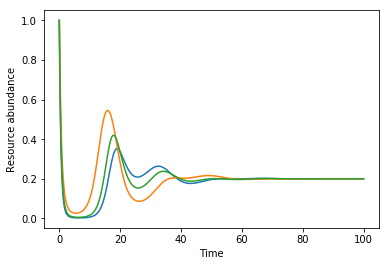

No handles with labels found to put in legend.


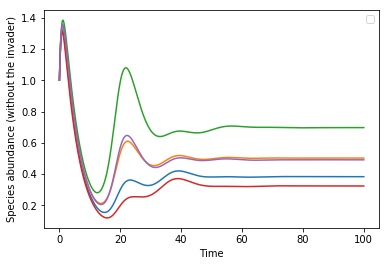

Steady-State ohne Invader


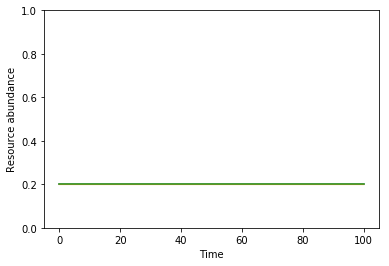

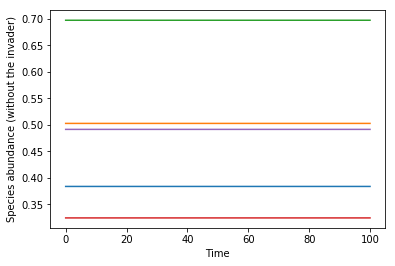

Mit Invader


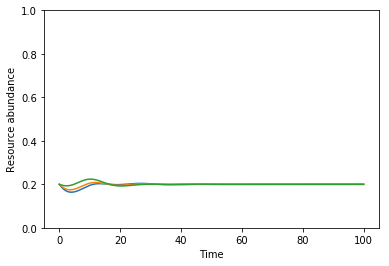

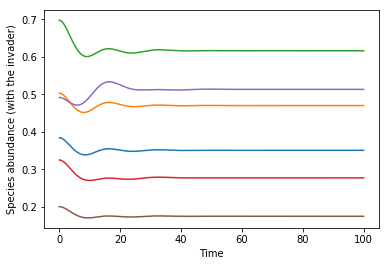

Steady-State mit Invader


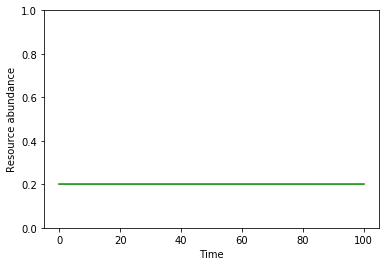

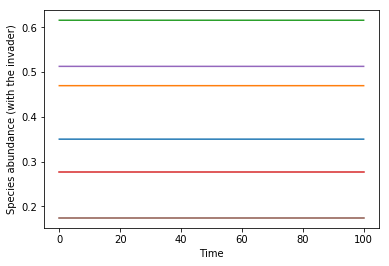

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
#from scipy.linalg import norm
from numpy.linalg import norm
from functools import partial
%matplotlib inline   

def create_parameter (number_species, number_resources):
    
    """ Funktion soll am Ende ein Dictionary bekommen, welches zufällige Werte beinhaltet, die zu den jeweiligen Parametern zugeordnet sind. 
    Die Anzahl der Werte der jeweiligen Parametern wird durch die Eingabe 'number_resources' und 'number_species' bestimmt. Im Gegensatz zu der Funktion
    'get_parameters' beinhaltet diese Funktion auch die Matrix a, die mit Zufallswerte gefüllt ist."""
    
    parameter_dict={}
    liste_parameter = []
    for i in ["w","r","K"]:
        parameter_dict[i] = np.repeat(1,number_resources)
            
    parameter_dict["T"] = np.repeat(0.2,number_species)
    parameter_dict["c"] = np.repeat(1,number_species)
    
    parameter_dict["number_species"] = len(parameter_dict["c"])
    parameter_dict["number_resources"] = len(parameter_dict["w"])
    
    a = np.random.rand(number_species,number_resources)
    a = a/a.sum(axis=1,keepdims=1)
    
    parameter_dict["a"] = a   
    
    return parameter_dict
    
class MacArther_C_R_2():    # zum Testen für steady-state -> timecourse fehlt
   
    def __init__(self, dict_parameter): #when using the function the first time it asks for parameters
        self.dict_parameter = dict_parameter
        self.number_species = dict_parameter["number_species"]
        self.number_resources = dict_parameter["number_resources"]
        self.T = dict_parameter["T"]
        self.c = dict_parameter["c"]
        self.w = dict_parameter["w"]
        self.r = dict_parameter["r"]
        self.K = dict_parameter["K"]
    
        #a = np.random.rand(self.number_species, self.number_resources)
        #self.a = a/a.sum(axis=1,keepdims=1)
        self.a = dict_parameter["a"]
    

    #h function
    def h(self, R):
        h = self.r * R / self.K * (self.K - R)
        return h

    #model
    def mcr(self, t,y):        # andere Parameter werden durch self aufgerufen
        X = y[:self.number_species]                            
        R = y[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)
        dRdt = self.h(R) - (self.a*R).T.dot(X)
        output = np.concatenate((dXdt,dRdt),axis=None)
        return output
    
    def timecourse(self, y, t):
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)            
        cnt = 1
        sol = [y]
        while cnt < len(t):
            sol.append(integ.integrate(t[cnt]))
            cnt += 1
        return np.array(sol)
    
    def steadystate(self,y, tmax = 10000, threshold=1e-5):                   # Anfangs 1e-9, aber threshold war zu niedrig, sodass kein steady-state errechnet werden konnte.
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)    
        ss = y
        t = range(tmax)
        cnt = 1
        while cnt < len(t):
            #print(cnt)
            ss_new = integ.integrate(t[cnt])
            if norm(ss-ss_new) < threshold:
                return ss_new
            else:
                ss = ss_new
                cnt += 1
                
    
    
    def expand_system (self ,anzahl = 1):

        """ Diese Funktion soll lediglich nur die Speziesparameter, die in der Klasse MacArther_C_R_2 abgespeichert sind, entsprechend erweitern. 
        Das Argument 'anzahl' dient dazu, die Anzahl an Spezies um den gewünschten Wert zu erweitern. Wenn nichts eingegeben wird, dann wird immer 
        angenommen, dass sich die Anzahl der Spezies um 1 erweitert."""

        p = self.dict_parameter.copy()  #shallow copy -> Referenz wird nicht kopiert -> Original wird nicht verändert


        for i in (range(anzahl)):

            self.T = np.append(self.T,0.2)
            self.c = np.append(self.c,1)
            k = np.random.rand( 1 , self.number_resources)
            k = k/k.sum(axis=1,keepdims=1)
            self.a = np.append(self.a,k,0)
            
        return p

    def expand_y0 (self, y0, n = 1, anfangswert = 1):

        """ Diese Funktion soll die Anfangswerte in y0 um die Anzahl der Invader n mit 1 erweitern. Wenn für n nichts eingesetzt wird,
         dann nimmt die Funktion an, dass y0 nur ein Anfangswert 1 hinzugefügt wird"""


        X0 = y0[:self.number_species]
        R0 = y0[self.number_species:]
        
        self.number_species+= 1 
        
        for i in range (n):
            X0 = np.append(X0,anfangswert)
        y0 = np.concatenate((X0,R0),axis=None)
        
        return y0
    
# Normal

t = np.linspace(0,100,1000)

Task3 = MacArther_C_R_2(create_parameter(5,3))   #30 Spezies und 40 Ressourcen

R0 = np.repeat(1,Task3.number_resources)
X0 = np.repeat(1,Task3.number_species)
y0 = np.concatenate((X0,R0),axis=None)

sol1_1 = Task3.timecourse(y0,t)
print("Ohne Invader")
plt.plot(t,sol1_1[:,Task3.number_species:])
plt.xlabel('Time')
plt.ylabel('Resource abundance')
plt.show()
plt.plot(t,sol1_1[:,:Task3.number_species])
plt.xlabel('Time')
plt.ylabel('Species abundance (without the invader)')
plt.legend()
plt.show() 

# Normal - steady-state

k = Task3.steadystate(y0)

sol1_2 = Task3.timecourse(k,t)

plt.plot(t,sol1_2[:,Task3.number_species:])
print("Steady-State ohne Invader")
plt.xlabel('Time')
plt.ylabel('Resource abundance')
plt.ylim(0,1)######################################
plt.show()
plt.plot(t,sol1_2[:,:Task3.number_species])
plt.xlabel('Time')
plt.ylabel('Species abundance (without the invader)')
plt.show()

# Invasion
Task3.expand_system()
y0_neu = Task3.expand_y0(k, anfangswert = 0.2)

sol2_1 = Task3.timecourse(y0_neu,t)
print("Mit Invader")
plt.plot(t,sol2_1[:,(Task3.number_species):])
plt.xlabel('Time')
plt.ylabel('Resource abundance')
plt.ylim(0,1)#############################
plt.show()
plt.plot(t,sol2_1[:,:Task3.number_species])
plt.xlabel('Time')
plt.ylabel('Species abundance (with the invader)')
plt.show()


# Invasion - steady-state

p = Task3.steadystate(y0_neu)

sol2_2 = Task3.timecourse(p,t)
print("Steady-State mit Invader")
plt.plot(t,sol2_2[:,Task3.number_species:])

plt.xlabel('Time')
plt.ylabel('Resource abundance')
plt.ylim(0,1)#############################
plt.show()
plt.plot(t,sol2_2[:,:Task3.number_species])
plt.xlabel('Time')
plt.ylabel('Species abundance (with the invader)')
plt.show()